# Table of Contents
 <p><div class="lev1 toc-item"><a href="#The-usual-data-preparations" data-toc-modified-id="The-usual-data-preparations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The usual data preparations</a></div><div class="lev1 toc-item"><a href="#New-type-for-GP-with-covariates" data-toc-modified-id="New-type-for-GP-with-covariates-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>New type for GP with covariates</a></div><div class="lev1 toc-item"><a href="#Optimize-with-Tucson-Unified-District-recent-data" data-toc-modified-id="Optimize-with-Tucson-Unified-District-recent-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Optimize with Tucson Unified District recent data</a></div><div class="lev1 toc-item"><a href="#2-GP-analysis-of-treatment-effect" data-toc-modified-id="2-GP-analysis-of-treatment-effect-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>2 GP analysis of treatment effect</a></div>

In our last meeting, LukeM suggested that I try fitting the system parameters just using the data from the biggest school district. That way we know for sure that the treatment isn't affecting those estimates. It's a valid concern, so let's go ahead and try it!

# The usual data preparations

In [51]:
using LaTeXStrings
using GaussianProcesses
using GaussianProcesses: grad_slice!, cov!, addcov!, KernelData
import GaussianProcesses: get_params, set_params!, num_params
import GaussianProcesses: distance, optimize!
import GaussianProcesses: Mean, Kernel, grad_stack!, grad_stack
import PDMats: AbstractPDMat, PDMat
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end

In [3]:
recent = Tucson_sales[:,:SaleDate].>=201500
recent_in_believable = Tucson_sales[believable,:SaleDate].>201500
Y_dict=Dict{String, Vector{Float64}}()
X_dict=Dict{String, Array{Float64,2}}()
recent_Y_dict=Dict{String, Vector{Float64}}()
recent_X_dict=Dict{String, Array{Float64,2}}()
schdistrs = unique(Tucson_sales[:,:SchDistr])
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
sentinels=Dict{Tuple{String,String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end
sum(recent & believable)

 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in transpose(::DataFrames.DataFrame) at ./deprecated.jl:771
 in ctranspose(::DataFrames.DataFrame) at ./operators.jl:310
 in macro expansion; at ./In[3]:10 [inlined]
 in anonymous at ./<missing>:?
 in include_string(::String, ::String) at ./loading.jl:380
 in execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/.julia/v0.5/IJulia/src/execute_request.jl:170
 in eventloop(::ZMQ.Socket) at /Users/imolk/.julia/v0.5/IJulia/src/IJulia.jl:143
 in (::IJulia.##25#31)() at ./task.jl:360
while loading In[3], in expression starting on line 8


5349

In [4]:
recent_GP_dict=Dict{String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern_ = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        println("no data for ", name)
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern_, log(σy))
    recent_GP_dict[name] = fit
end
schdistrs_have = collect(keys(recent_GP_dict))
recent_multiGP = GaussianProcesses.GP[recent_GP_dict[name] for name in schdistrs_have]
;

no data for Tanque Verde Unified District


In [5]:
nobsv_ = sum([gp.nobsv for gp in recent_multiGP])
for_mm = copy(Tucson_sales[believable & recent,:])
for_mm[:SQFT] =  for_mm[:SQFT] .- mean(for_mm[:SQFT])
for_mm[:SQFT] = for_mm[:SQFT] ./ std(for_mm[:SQFT])
for_mm[:ROOMS] = for_mm[:ROOMS] .- mean(for_mm[:ROOMS])
for_mm[:ROOMS] = for_mm[:ROOMS] ./ std(for_mm[:ROOMS])
for_mm[:STORIES] = for_mm[:STORIES] .- mean(for_mm[:STORIES])
for_mm[:STORIES] = for_mm[:STORIES] ./ std(for_mm[:STORIES])
reordering = collect(1:nobsv_)
istart = 1
for name in schdistrs_have
    indices = find(for_mm[:SchDistr] .== name)
    nobsv_schdistr = length(indices)
    iend = istart+nobsv_schdistr-1
    reordering[istart:iend,:] = indices
    istart = iend+1
end
for_mm = for_mm[reordering,:]
;

In [6]:
contrasts_dict = Dict()
for (term,col) in eachcol(for_mm)
    DataFrames.is_categorical(col) || continue
    contrasts_dict[term] = DataFrames.FullDummyCoding()
end
mf=DataFrames.ModelFrame(SQFT ~ SQFT + QUALITY + STORIES + CLASS + ROOF + GARAGE, 
    for_mm, 
    contrasts=contrasts_dict)
mm=ModelMatrix(mf)
p = size(mm,2)
D_=mm.m;

In [7]:
coefnames(mf)

25-element Array{String,1}:
 "(Intercept)"                    
 "SQFT"                           
 "QUALITY: Excellent"             
 "QUALITY: Fair"                  
 "QUALITY: Good"                  
 "QUALITY: Minimum"               
 "STORIES"                        
 "CLASS: R-1"                     
 "CLASS: R-2"                     
 "CLASS: R-3"                     
 "CLASS: R-4"                     
 "CLASS: R-5"                     
 "ROOF: Asbestos"                 
 "ROOF: Asphalt"                  
 "ROOF: Built Up"                 
 "ROOF: Metal"                    
 "ROOF: Other"                    
 "ROOF: Prepared Roll"            
 "ROOF: Slate"                    
 "ROOF: Tile"                     
 "ROOF: Wood"                     
 "GARAGE: Carport"                
 "GARAGE: Garage"                 
 "GARAGE: Garage & Carport (both)"
 "GARAGE: None"                   

# New type for GP with covariates

In [8]:
βkern_ = GaussianProcesses.LinIso(log(1.0))
type GPCovars   
    m:: Mean                # Mean object
    k::Kernel               # Kernel object
    βkern::Kernel
    logNoise::Float64       # log standard deviation of observation noise
    
    # Observation data
    nobsv::Int              # Number of observations
    X::Matrix{Float64}      # Input observations
    y::Vector{Float64}      # Output observations
    D::Array{Float64,2}
    data::KernelData        # Auxiliary observation data (to speed up calculations)
    βdata::KernelData
    p::Int                  # Dimensions of covariates
    dim::Int                # Dimension of inputs
    
    # Auxiliary data
    cK::AbstractPDMat       # (k + exp(2*obsNoise))
    alpha::Vector{Float64}  # (k + exp(2*obsNoise))⁻¹y
    mLL::Float64            # Marginal log-likelihood
    dmLL::Vector{Float64}   # Gradient marginal log-likelihood

    function GPCovars(X::Matrix{Float64}, 
        y::Vector{Float64}, 
        D::Matrix{Float64},
        m::Mean, 
        k::Kernel,
        βkern::Kernel,
        logNoise::Float64=-1e8,
        )
        dim, nobsv = size(X)
        p, nobsv2 = size(D)
        nobsv == nobsv2 || throw(ArgumentError("X and D should have the same number of rows"))
        length(y) == nobsv || throw(ArgumentError("X and y should have the same number of rows"))
        gp = new(m, k, βkern, logNoise, nobsv, X, y, D, KernelData(k, X), KernelData(βkern, D), p, dim)
        update_mll!(gp)
        return gp
    end
end

In [52]:
function update_mll!(gp::GPCovars, cK::Matrix{Float64})
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    gp.cK = PDMat(cK)
    gp.alpha = gp.cK \ (gp.y .- μ)
    gp.mLL = -dot((gp.y-μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0
end

update_mll! (generic function with 2 methods)

In [53]:
function update_mll!(gp::GPCovars)
    Σbuffer = Array(Float64, gp.nobsv, gp.nobsv)
    update_mll!(gp, Σbuffer)
end

update_mll! (generic function with 2 methods)

In [54]:
function update_mll!!(gp::GPCovars)
    cK = gp.cK.mat
    μ = mean(gp.m, gp.X)
    cov!(cK, gp.βkern, gp.D, gp.βdata)
    addcov!(cK, gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        cK[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    chol_buffer = gp.cK.chol.factors
    copy!(chol_buffer, cK)
    chol = cholfact!(Symmetric(chol_buffer))
    gp.cK = PDMats.PDMat(cK, chol)
    gp.alpha = gp.cK \ (gp.y - μ)
    gp.mLL = -dot((gp.y - μ),gp.alpha)/2.0 - logdet(gp.cK)/2.0 - gp.nobsv*log(2π)/2.0 # Marginal log-likelihood
end

update_mll!! (generic function with 2 methods)

In [55]:
function update_mll_and_dmll!(gp::GPCovars,
    Kgrad::Matrix{Float64}
    ; 
    noise::Bool=true, # include gradient component for the logNoise term
    mean::Bool=true, # include gradient components for the mean parameters
    kern::Bool=true, # include gradient components for the spatial kernel parameters
    beta::Bool=true, # include gradient components for the linear regression prior terms
    )
    update_mll!!(gp)
    n_mean_params = num_params(gp.m)
    n_kern_params = num_params(gp.k)
    n_beta_params = num_params(gp.βkern)
    gp.dmLL = Array(Float64, noise + mean*n_mean_params + kern*n_kern_params + beta*n_beta_params)
    logNoise = gp.logNoise
    α = gp.alpha
    ααinvcKI = α*α' - gp.cK \ eye(gp.nobsv)
    i=1
    if noise
        gp.dmLL[i] = exp(2.0*logNoise)*trace(ααinvcKI)
        i+=1
    end
    if mean
        Mgrads = grad_stack(gp.m, gp.X)
        for j in 1:n_mean_params
            gp.dmLL[i] = dot(Mgrads[:,j],gp.alpha)
            i += 1
        end
    end
    if kern
        for iparam in 1:n_kern_params
            grad_slice!(Kgrad, gp.k, gp.X, gp.data, iparam)
            gp.dmLL[i] = dot(Kgrad,ααinvcKI)/2.0
            i+=1
        end
    end
    if beta
        for iparam in 1:n_beta_params
            grad_slice!(Kgrad, gp.βkern, gp.D, gp.βdata, iparam)
            gp.dmLL[i] = dot(ααinvcKI,Kgrad)/2.0
            i+=1
        end
    end
end


update_mll_and_dmll! (generic function with 1 method)

In [56]:
function set_params!(gp::GPCovars, hyp::Vector{Float64}; 
                    noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    i=1
    if noise
        gp.logNoise = hyp[i]
        i+=1
    end
    if mean
        set_params!(gp.m, hyp[i:i+num_params(gp.m)-1])
        i+=num_params(gp.m)
    end
    if kern
        set_params!(gp.k, hyp[i:i+num_params(gp.k)-1])
        i+=num_params(gp.k)
    end
    if beta
        set_params!(gp.βkern, hyp[i:i+num_params(gp.βkern)-1])
        i+=num_params(gp.βkern)
    end
end

set_params! (generic function with 25 methods)

In [57]:
function get_params(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true)
    params = Float64[]
    if noise; push!(params, gp.logNoise); end
    if mean;  append!(params, get_params(gp.m)); end
    if kern; append!(params,  get_params(gp.k)); end
    if beta; append!(params,  get_params(gp.βkern)); end
    return params
end

get_params (generic function with 25 methods)

In [58]:
function optimize!(gp::GPCovars; noise::Bool=true, mean::Bool=true, kern::Bool=true, beta::Bool=true, 
                    method=ConjugateGradient(), kwargs...)
    Kgrad_buffer = Array(Float64, gp.nobsv, gp.nobsv)
    function mll(hyp::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll!!(gp)
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end        
    end

    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        try
            set_params!(gp, hyp; noise=noise, mean=mean, kern=kern, beta=beta)
            update_mll_and_dmll!(gp, Kgrad_buffer; noise=noise, mean=mean, kern=kern, beta=beta)
            grad[:] = -gp.dmLL
            return -gp.mLL
        catch err
             if !all(isfinite(hyp))
                println(err)
                return Inf
            elseif isa(err, ArgumentError)
                println(err)
                return Inf
            elseif isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end 
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = get_params(gp;  noise=noise, mean=mean, kern=kern, beta=beta)  # Initial hyperparameter values
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    set_params!(gp, results.minimum; noise=noise, mean=mean, kern=kern, beta=beta)
    return results
end

optimize! (generic function with 1 method)

# Optimize with Tucson Unified District recent data

In [59]:
district="Tucson Unified District" # biggest district

"Tucson Unified District"

In [35]:
_X = recent_X_dict[district]'
_Y = recent_Y_dict[district]
_Dd = D_[for_mm[:SchDistr].==district,:]'
_m = MeanConst(mean(_Y))
gp=GPCovars(_X, _Y, _Dd, _m, kern_, βkern_, log(σy))
;

In [62]:
opt_out=optimize!(gp, iterations=10, x_tol=1e-4, f_tol=1e-3)

New linesearch
bracketing: ia = 1, ib = 2, c = 0.2, phic = 147911.65935883747, dphic = 2.565187746730747e6
linesearch: ia = 1, ib = 2, a = 0.0, b = 0.2, phi(a) = -978.3651510272671, phi(b) = 147911.65935883747
secant2: a = 0.0, b = 0.2, c = 0.002758913496837616
update: ia = 1, a = 0.0, ib = 2, b = 0.2, c = 0.002758913496837616, phic = -976.6298233483863, dphic = 33995.718638698905
secant2: iA = 1, iB = 3, ic = 3
secant2: second c = 0.0001098246855840839
update: ia = 1, a = 0.0, ib = 3, b = 0.002758913496837616, c = 0.0001098246855840839, phic = -982.1490075299976, dphic = -33025.77341730513
secant2 output: a = 0.0001098246855840839, b = 0.002758913496837616
Linesearch: secant succeeded
linesearch: ia = 4, ib = 3, a = 0.0001098246855840839, b = 0.002758913496837616, phi(a) = -982.1490075299976, phi(b) = -976.6298233483863
secant2: a = 0.0001098246855840839, b = 0.002758913496837616, c = 0.001415200083220279
secant2: first c satisfied Wolfe conditions
New linesearch
Wolfe condition satis

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.9123383151630784,11.97086383473769, ...]
 * Minimizer: [-1.8363654696741565,11.970892387954063, ...]
 * Minimum: -1.019191e+03
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-04: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-03: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 13
 * Gradient Calls: 10

In [63]:
opt_out.minimum

5-element Array{Float64,1}:
 -1.83637  
 11.9709   
  7.39682  
 -1.59932  
  0.0924345

In [64]:
@printf("σ_y: %.4f\n", exp(gp.logNoise))
@printf("σ_f: %.4f\n", √(gp.k.σ2))
@printf("σ_β: %.4f\n", 1/√gp.βkern.ℓ2)
@printf("ℓ: %.4f\n", √(gp.k.ℓ2))

σ_y: 0.1594
σ_f: 0.2020
σ_β: 0.9117
ℓ: 1630.7867


# 2 GP analysis of treatment effect

In [65]:
function get_ΣYβ!(gp::GPCovars)
    Σ = cov(gp.k, gp.X, gp.data)
    for i in 1:gp.nobsv
        Σ[i,i] += max(exp(2*gp.logNoise),1e-8)
    end
    return PDMats.PDMat(Σ)
end

get_ΣYβ! (generic function with 1 method)

In [66]:
ΣY_β = get_ΣYβ!(gp);

In [70]:
size(ΣY_β)

(4040,4040)

In [71]:
size(gp.D)

(25,4040)

In [80]:
tmp = PDMats.X_invA_Xt(ΣY_β, gp.D)
for i in 1:p
    tmp[i,i] += gp.βkern.ℓ2
end
m = mean(gp.m,gp.X)
βhat = (tmp \ gp.D) * (ΣY_β \ (gp.y.-m))
βhat_dict=Dict(zip(coefnames(mf), βhat))

Dict{String,Float64} with 25 entries:
  "ROOF: Built Up" => -0.0260889
  "CLASS: R-4" => 0.223833
  "ROOF: Metal" => 0.160252
  "CLASS: R-2" => -0.174821
  "CLASS: R-1" => -0.397925
  "ROOF: Other" => -0.0116815
  "ROOF: Tile" => -0.0192543
  "ROOF: Wood" => -0.0471326
  "QUALITY: Good" => 0.0225683
  "ROOF: Prepared Roll" => -0.0302376
  "GARAGE: Garage" => 0.0368734
  "QUALITY: Excellent" => 0.19926
  "ROOF: Asphalt" => -0.0422292
  "GARAGE: None" => -0.0518622
  "STORIES" => -0.0926329
  "GARAGE: Carport" => -0.0222729
  "QUALITY: Minimum" => -0.177761
  "(Intercept)" => 0.00609289
  "CLASS: R-5" => 0.327357
  "CLASS: R-3" => 0.0276493
  "ROOF: Slate" => 0.0535204
  "SQFT" => 0.203643
  "QUALITY: Fair" => -0.0379749
  "ROOF: Asbestos" => -0.0310553
  "GARAGE: Garage & Carport (both)" => 0.0433547

In [86]:
resid = log(for_mm[:SalePrice]) - D_*βhat
resid_dict=Dict{String, Vector{Float64}}()
for name in schdistrs_have
    resid_dict[name] = resid[for_mm[:SchDistr].==name]
end

In [87]:
resid_GP_dict=Dict{String, GP}()
for name in schdistrs
    X = recent_X_dict[name]
    if size(X,1)==0
        continue
    end
    Y = resid_dict[name]
    fit = GP(X', Y, gp.m, gp.k, gp.logNoise)
    resid_GP_dict[name] = fit
end

In [90]:
distrA = "Amphitheater Unified District"
distrB = "Tucson Unified District"
X◫ = hcat(sentinels[distrA,distrB].coordinates...)
n◫ = size(X◫, 2)
resid_pred_A = GaussianProcesses.predict(resid_GP_dict[distrA], X◫; full_cov=true)
resid_pred_B = GaussianProcesses.predict(resid_GP_dict[distrB], X◫; full_cov=true)
resid_μposterior = resid_pred_A[1].-resid_pred_B[1]
resid_Σposterior = resid_pred_A[2]+resid_pred_B[2]
;

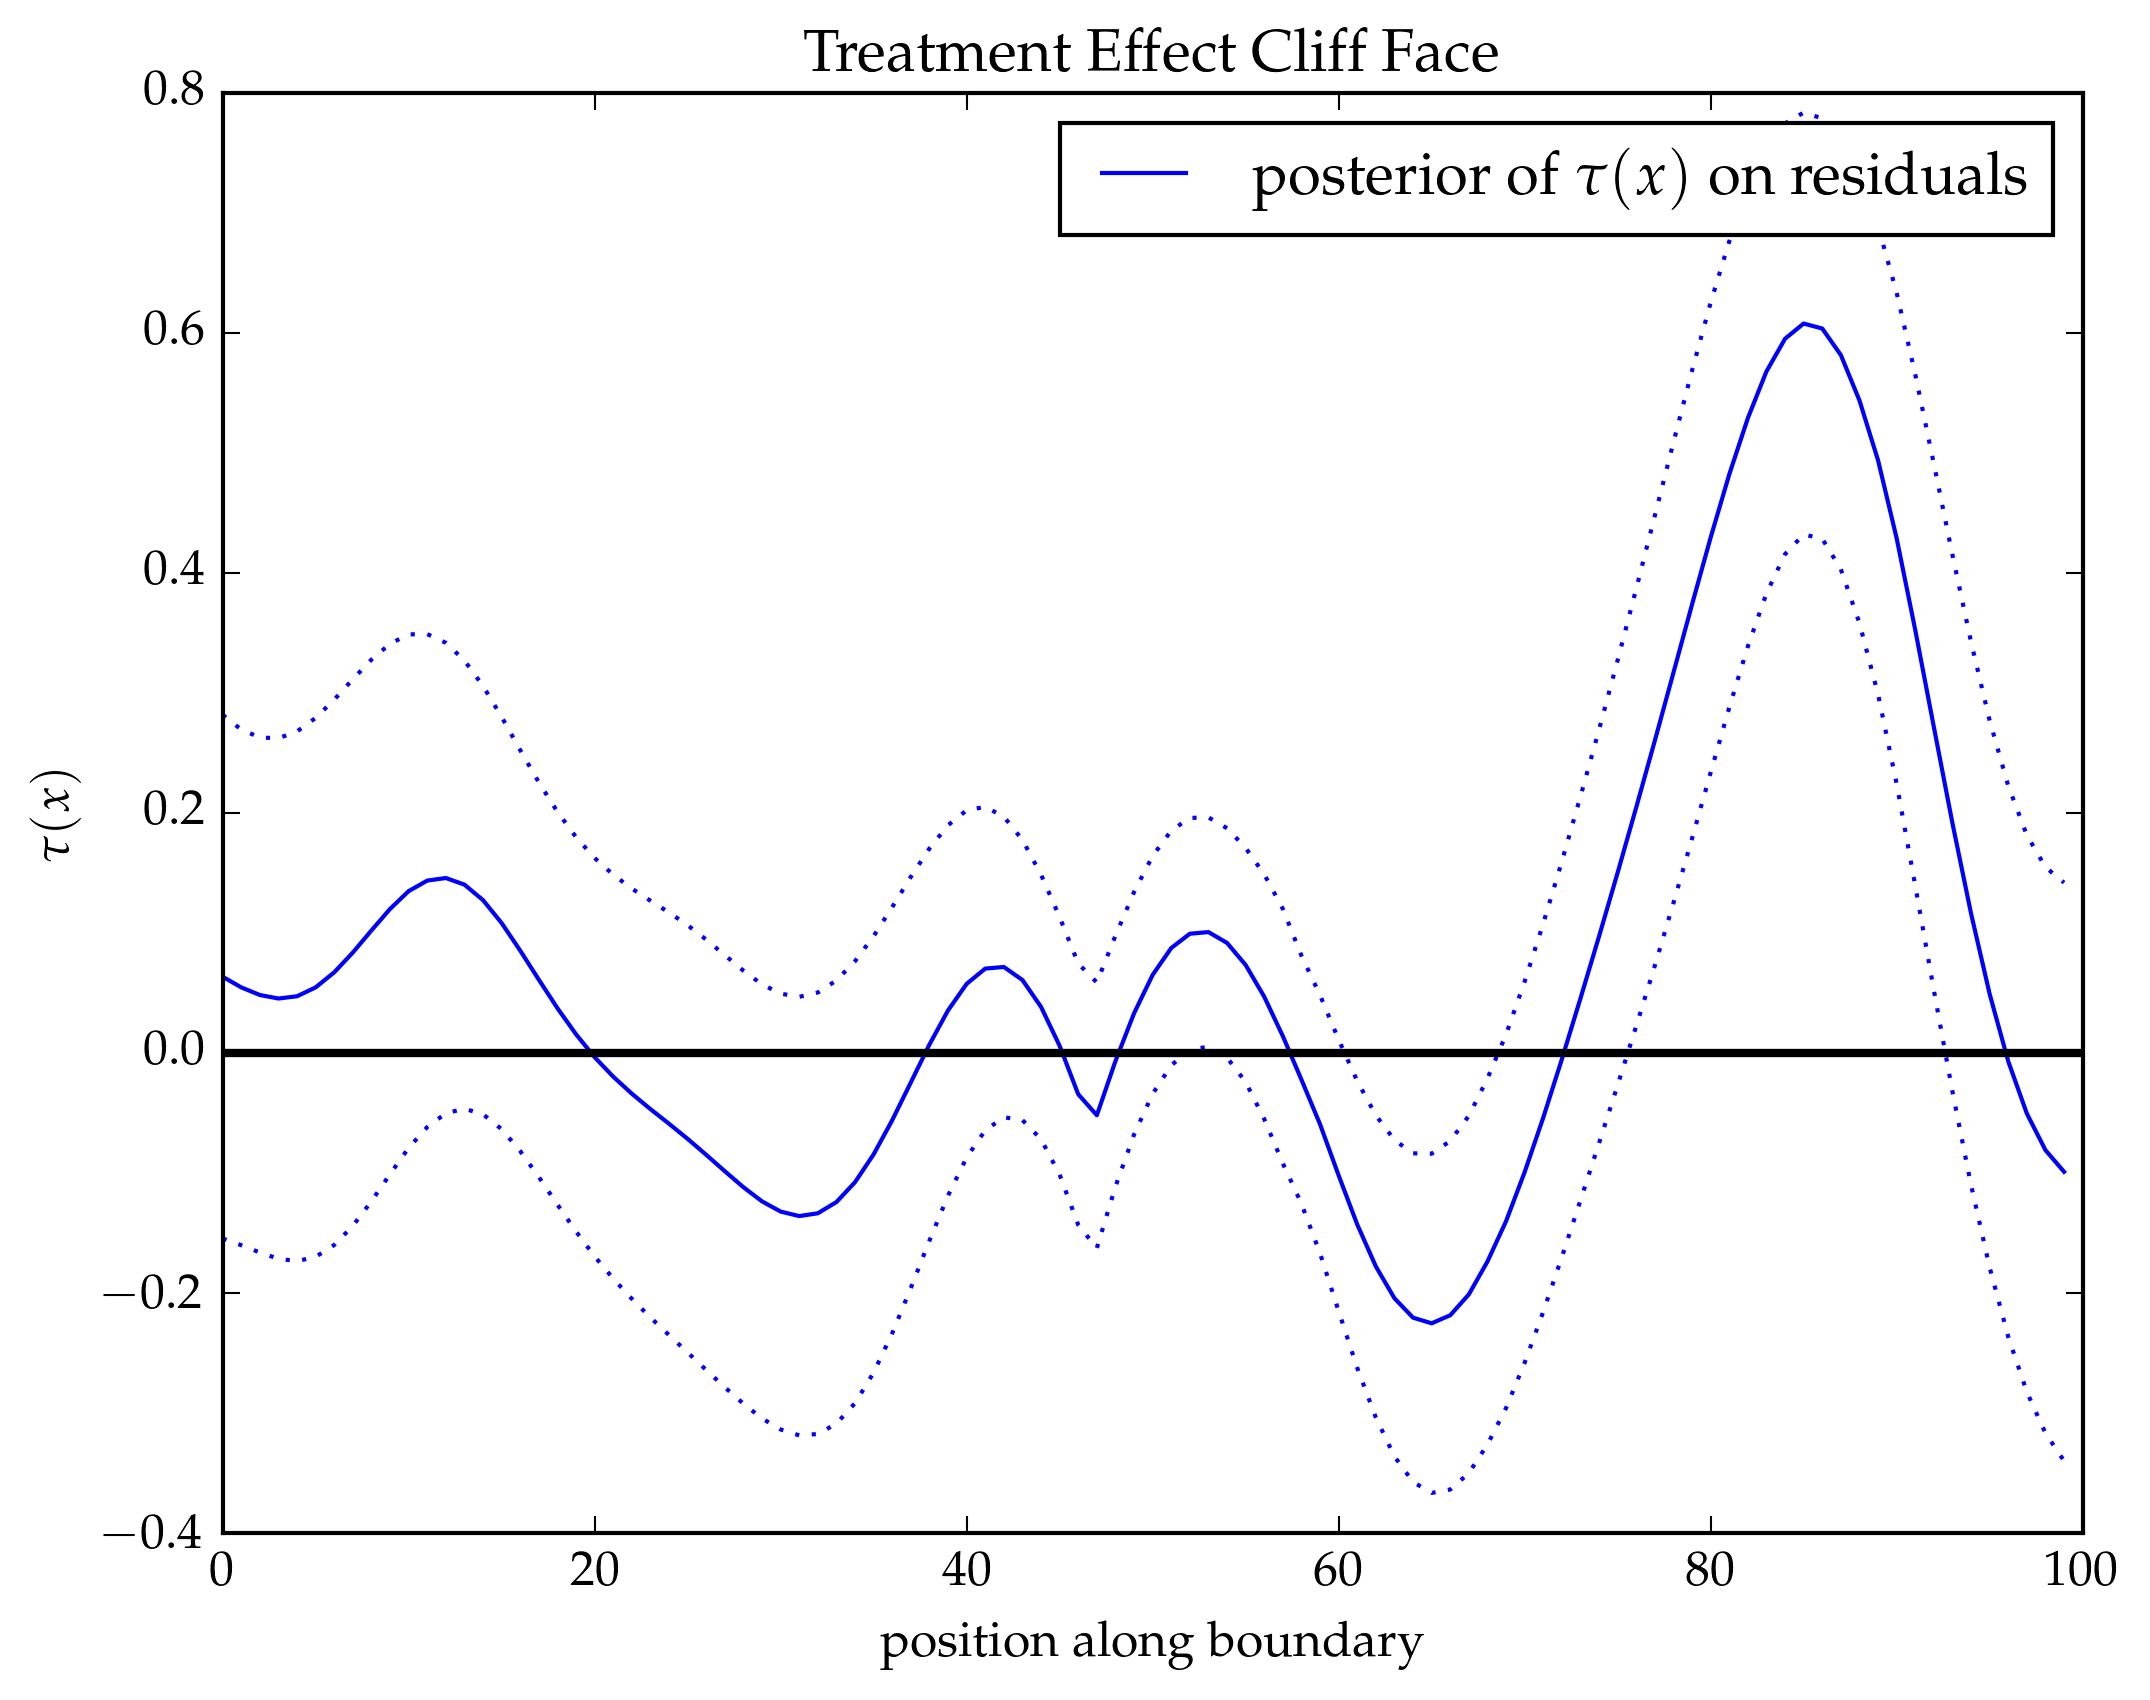

In [91]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

Still get the same answer! It doesn't look like fitting the linear regression parameters to the entire dataset is biasing the results towards zero.